In [212]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches_indices
from IPython.display import display



In [213]:
USE_GPU = True
TRAIN = True

In [214]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1726163614.025777    4360 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726163614.027526    4360 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726163614.028866    4360 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726163614.030459    4360 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [215]:
IMAGE_SIZE = 14
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
LEARNING_RATE = 0.005
EPOCHS = 100
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
NUM_LANGS = 100

In [216]:
data = np.load("./data/language_parameters.npz", allow_pickle=True)
language_parameters = data["language_parameters"]
languages = data["languages"]
parameters = data["parameters"]

l = language_parameters.shape[0]

X = np.hstack([language_parameters.copy(), np.zeros((l, 8))]).reshape(l, IMAGE_SIZE, IMAGE_SIZE)
X = np.expand_dims(X, axis=3)

MAX_VALUE = X.max()

X /= MAX_VALUE

assert language_parameters.shape[0] == languages.shape[0]

language_parameters.shape, languages.shape, parameters.shape, X.shape, Z_DIM

((2527, 188), (2527, 2), (188, 2), (2527, 14, 14, 1), 196)

In [217]:
critic = Sequential(
    [
        Input(shape=X.shape[1:]),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * IMAGE_SIZE, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_126 (Conv2D)             │ (None, 7, 7, 14)       │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_140 (LeakyReLU)     │ (None, 7, 7, 14)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_127 (Conv2D)             │ (None, 4, 4, 28)       │         3,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_141 (LeakyReLU)     │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_128 (Conv2D)             │ (None, 2, 2, 56)       │        14,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_142 (LeakyReLU)     │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 2, 2, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_129 (Conv2D)             │ (None, 1, 1, 112)      │        56,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_143 (LeakyReLU)     │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 1, 1, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_130 (Conv2D)             │ (None, 1, 1, 196)      │        88,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_144 (LeakyReLU)     │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 196)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,428 (634.48 KB)

 Trainable params: 162,428 (634.48 KB)

 Non-trainable params: 0 (0.00 B)

In [218]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=4, strides=2, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=4, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * IMAGE_SIZE, kernel_size=8, strides=1, padding="same", activation="sigmoid"
        ),
        layers.Reshape(X.shape[1:]),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_28 (Reshape)            │ (None, 1, 1, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_70             │ (None, 4, 4, 196)      │       614,656 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 4, 4, 196)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_131 (Conv2D)             │ (None, 2, 2, 112)      │       351,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 2, 2, 112)      │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_145 (LeakyReLU)     │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 2, 2, 112)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_132 (Conv2D)             │ (None, 1, 1, 56)       │       100,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_146 (LeakyReLU)     │ (None, 1, 1, 56)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_71             │ (None, 2, 2, 28)       │        25,088 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_147 (LeakyReLU)     │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_72             │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_133 (Conv2D)             │ (None, 2, 2, 28)       │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 2, 2, 28)       │           112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_148 (LeakyReLU)     │ (None, 2, 2, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_73             │ (None, 4, 4, 28)       │         3,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_134 (Conv2D)             │ (None, 1, 1, 56)       │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 1, 1, 56)       │           224 │
│ (BatchNormalization)            │                        │             

 Total params: 1,810,676 (6.91 MB)

 Trainable params: 1,810,172 (6.91 MB)

 Non-trainable params: 504 (1.97 KB)

In [219]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [220]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [221]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, latent_dim, num_img=10, display_on_epoch=10, figsize=(28, 28)):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.display_on_epoch = display_on_epoch
        self.figsize = figsize

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.display_on_epoch == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors).numpy()
            plt.figure(figsize=self.figsize)

            for i in range(self.num_img):
                _ = plt.subplot(1, self.num_img, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - c_gp: 0.3100 - c_loss: 3.0981 - c_wass_loss: -0.0021 - g_loss: -0.0046     

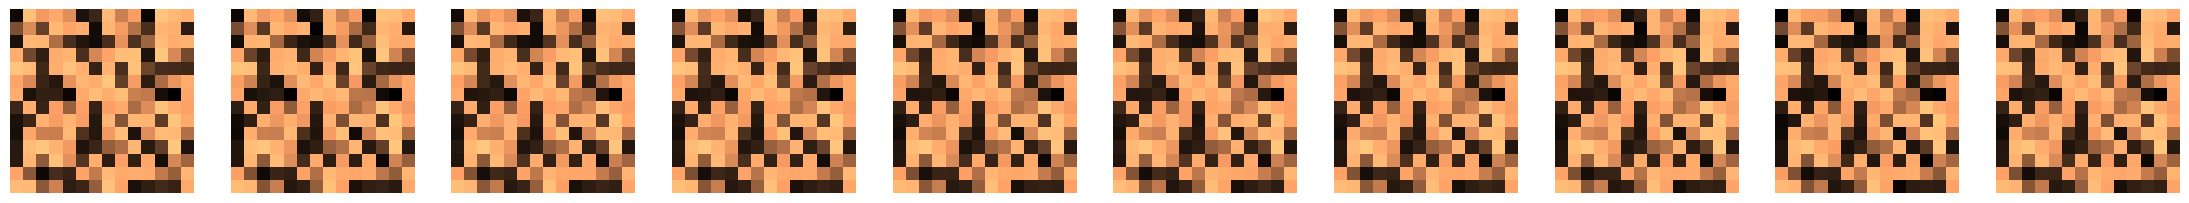

3/3 ━━━━━━━━━━━━━━━━━━━━ 51s 11s/step - c_gp: 0.2833 - c_loss: 2.8302 - c_wass_loss: -0.0023 - g_loss: -0.0049
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - c_gp: 0.0480 - c_loss: 0.4757 - c_wass_loss: -0.0042 - g_loss: -0.0120
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 5/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - c_gp: 0.0369 - c_loss: 0.3664 - c_wass_loss: -0.0031 - g_loss: -0.0166

/home/pappa/anaconda3/envs/conlanger/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.1176 - c_loss: 1.1731 - c_wass_loss: -0.0029 - g_loss: -0.0173
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - c_gp: 0.2049 - c_loss: 2.0476 - c_wass_loss: -0.0013 - g_loss: -0.0216    
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - c_gp: 0.0475 - c_loss: 0.4719 - c_wass_loss: -0.0035 - g_loss: -0.0297
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 11/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - c_gp: 0.2429 - c_loss: 2.4308 - c_wass_loss: 0.0015 - g_loss: -0.0264

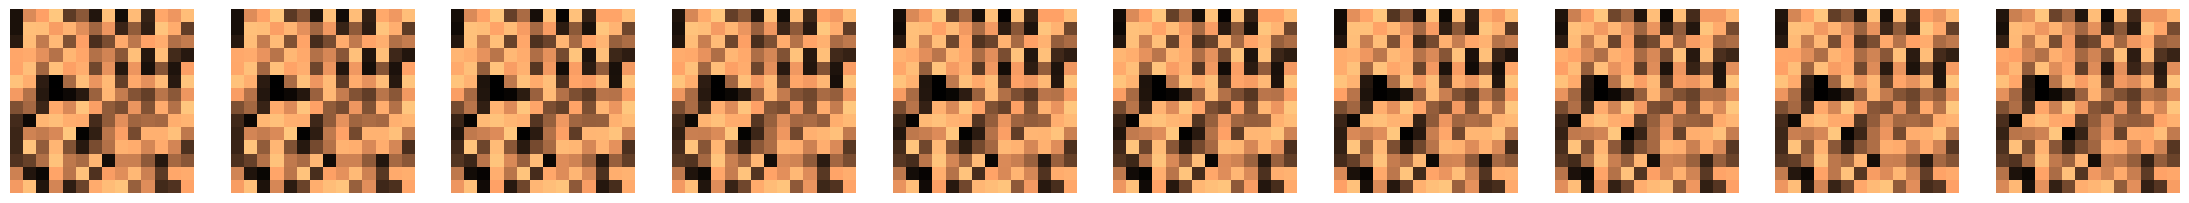

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - c_gp: 0.1550 - c_loss: 1.5498 - c_wass_loss: -1.5412e-04 - g_loss: -0.0264
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0946 - c_loss: 0.9434 - c_wass_loss: -0.0029 - g_loss: -0.0289
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.2323 - c_loss: 2.3223 - c_wass_loss: -0.0012 - g_loss: -0.0259
Epoch 16/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 17/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.2441 - c_loss: 2.4390 - c_wass_loss: -0.0022 - g_loss: -0.0216    
Epoch 18/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_

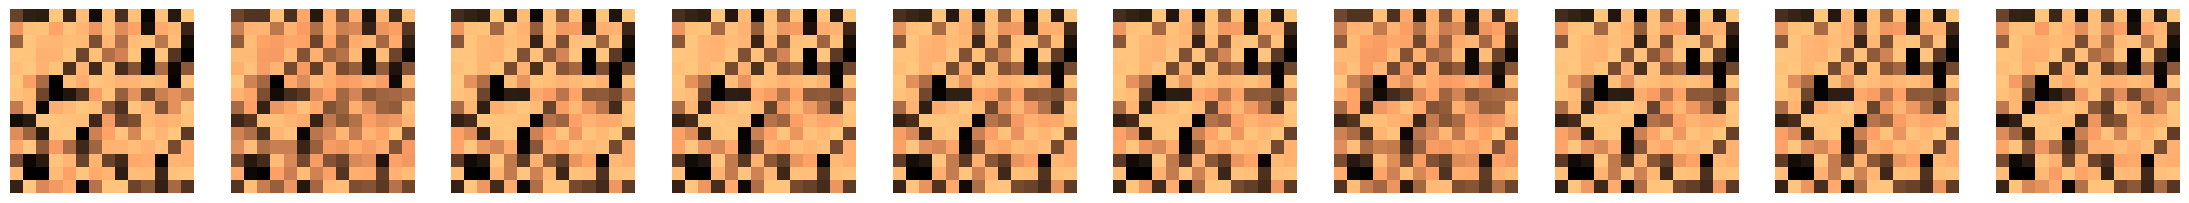

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - c_gp: 0.0793 - c_loss: 0.7916 - c_wass_loss: -0.0013 - g_loss: -0.0228
Epoch 22/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 23/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.1406 - c_loss: 1.4043 - c_wass_loss: -0.0016 - g_loss: -0.0255
Epoch 24/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 25/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0250 - c_loss: 0.2489 - c_wass_loss: -8.3351e-04 - g_loss: -0.0236
Epoch 26/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 27/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - c_gp: 0.0805 - c_loss: 0.8052 - c_wass_loss: -9.1646e-05 - g_loss: -0.0178
Epoch 28/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass

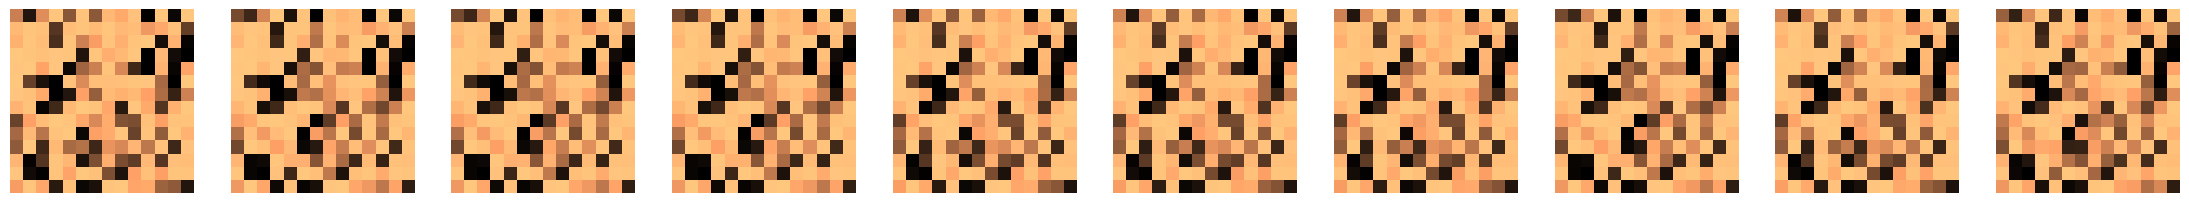

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - c_gp: 0.0391 - c_loss: 0.3929 - c_wass_loss: 0.0016 - g_loss: -0.0144
Epoch 32/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 33/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0281 - c_loss: 0.2824 - c_wass_loss: 0.0013 - g_loss: 0.0033    
Epoch 34/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 35/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0271 - c_loss: 0.2711 - c_wass_loss: -6.0259e-05 - g_loss: 0.0118
Epoch 36/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 37/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - c_gp: 0.0757 - c_loss: 0.7586 - c_wass_loss: 0.0012 - g_loss: 0.0113
Epoch 38/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss:

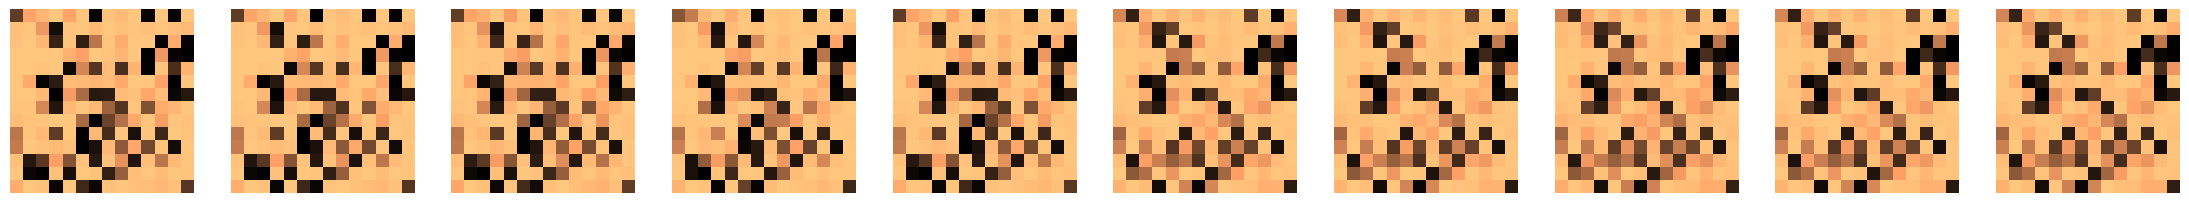

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - c_gp: 0.0184 - c_loss: 0.1832 - c_wass_loss: -3.0460e-04 - g_loss: 0.0197
Epoch 42/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 43/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0141 - c_loss: 0.1404 - c_wass_loss: -2.4482e-04 - g_loss: 0.0213
Epoch 44/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 45/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - c_gp: 0.0219 - c_loss: 0.2204 - c_wass_loss: 0.0011 - g_loss: 0.0225
Epoch 46/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 47/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - c_gp: 0.0151 - c_loss: 0.1515 - c_wass_loss: 1.2619e-04 - g_loss: 0.0271
Epoch 48/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_l

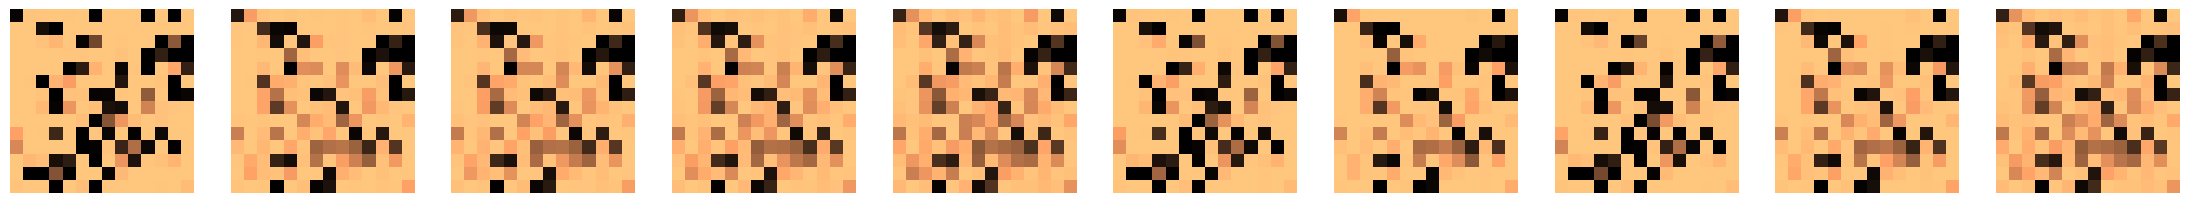

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - c_gp: 0.0223 - c_loss: 0.2234 - c_wass_loss: 8.0151e-04 - g_loss: 0.0341
Epoch 52/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 53/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0266 - c_loss: 0.2656 - c_wass_loss: -1.2085e-04 - g_loss: 0.0327
Epoch 54/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 55/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0176 - c_loss: 0.1759 - c_wass_loss: -7.4281e-05 - g_loss: 0.0347
Epoch 56/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 57/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0181 - c_loss: 0.1801 - c_wass_loss: -5.3381e-04 - g_loss: 0.0291
Epoch 58/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_w

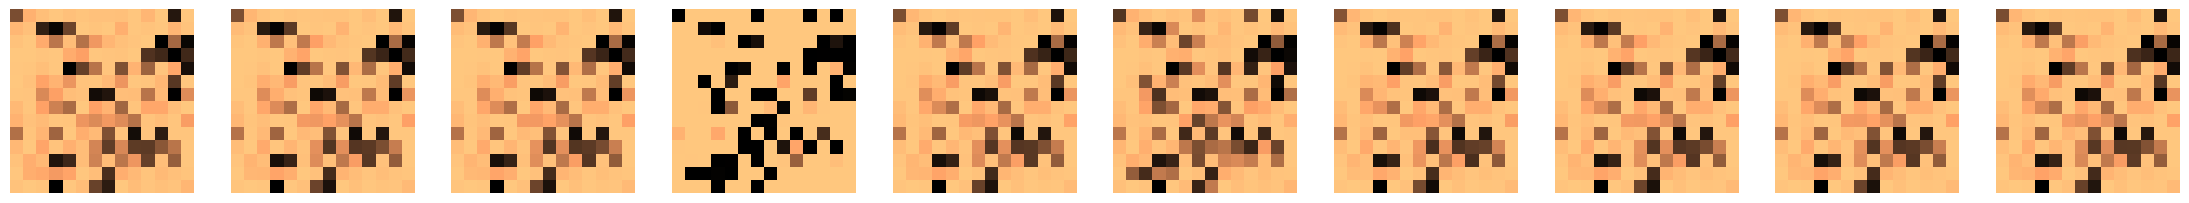

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - c_gp: 0.0168 - c_loss: 0.1668 - c_wass_loss: -0.0012 - g_loss: 0.0199
Epoch 62/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 63/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0264 - c_loss: 0.2621 - c_wass_loss: -0.0018 - g_loss: 0.0061
Epoch 64/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 65/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - c_gp: 0.0184 - c_loss: 0.1831 - c_wass_loss: -9.8910e-04 - g_loss: 6.7793e-05
Epoch 66/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 67/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0142 - c_loss: 0.1405 - c_wass_loss: -0.0017 - g_loss: -0.0058
Epoch 68/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_

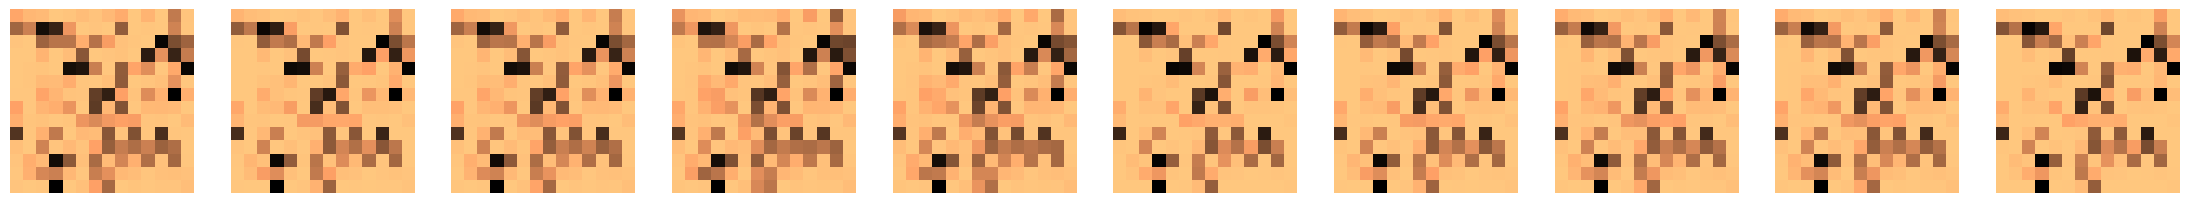

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - c_gp: 0.0173 - c_loss: 0.1716 - c_wass_loss: -0.0014 - g_loss: -0.0250
Epoch 72/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 73/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - c_gp: 0.0419 - c_loss: 0.4175 - c_wass_loss: -0.0015 - g_loss: -0.0416
Epoch 74/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 75/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.1276 - c_loss: 1.2763 - c_wass_loss: 8.6112e-05 - g_loss: -0.0442 
Epoch 76/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 77/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0163 - c_loss: 0.1644 - c_wass_loss: 9.5732e-04 - g_loss: -0.0263
Epoch 78/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_w

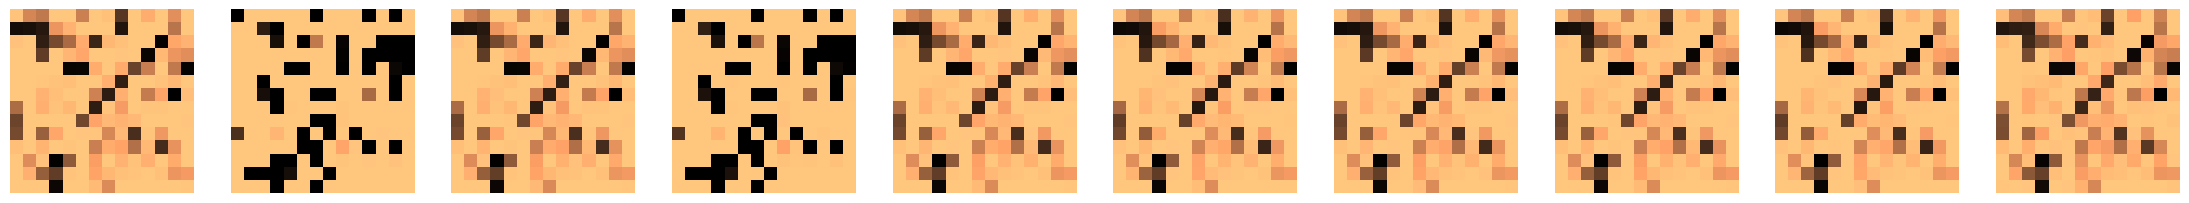

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - c_gp: 0.0173 - c_loss: 0.1733 - c_wass_loss: -4.7313e-05 - g_loss: 0.0019
Epoch 82/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 83/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0204 - c_loss: 0.2044 - c_wass_loss: 3.6387e-04 - g_loss: 0.0022      
Epoch 84/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 85/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0160 - c_loss: 0.1588 - c_wass_loss: -9.0155e-04 - g_loss: 0.0109
Epoch 86/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 87/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0176 - c_loss: 0.1756 - c_wass_loss: -6.7180e-04 - g_loss: 0.0067
Epoch 88/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00

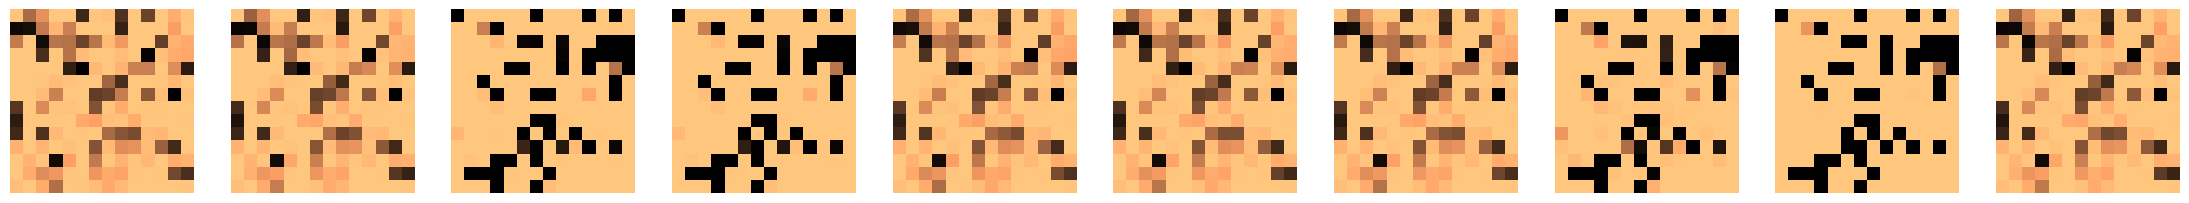

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - c_gp: 0.0139 - c_loss: 0.1381 - c_wass_loss: -5.9030e-04 - g_loss: -0.0040
Epoch 92/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 93/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0150 - c_loss: 0.1485 - c_wass_loss: -0.0020 - g_loss: 0.0072
Epoch 94/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 95/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0162 - c_loss: 0.1615 - c_wass_loss: -4.7657e-04 - g_loss: 0.0020 
Epoch 96/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 97/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - c_gp: 0.0130 - c_loss: 0.1303 - c_wass_loss: 3.7304e-04 - g_loss: 0.0169
Epoch 98/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_was

In [222]:
if TRAIN:
    wgangp.fit(
        X,
        epochs=EPOCHS,
        steps_per_epoch=3,
        callbacks=[
            ImageGenerator(latent_dim=Z_DIM),
        ],
    )

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


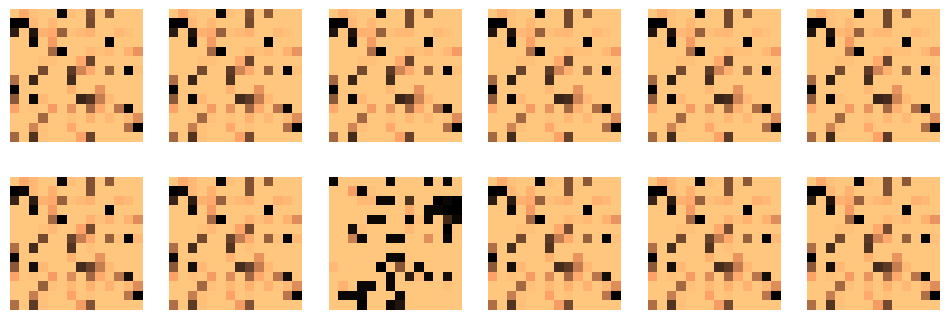

In [223]:
if TRAIN:
    
    noise = np.random.normal(size=(NUM_LANGS, Z_DIM))
    generated_language_parameters = generator.predict(noise)
    l = generated_language_parameters.shape[0]

    # normalise
    generated_language_parameters = (generated_language_parameters-np.min(generated_language_parameters))/(np.max(generated_language_parameters)-np.min(generated_language_parameters))

    # weirdness
    mean_lang = np.mean(X, axis=0).reshape(-1)
    diff_from_mean = np.array([np.mean(np.abs(mean_lang - g)) for g in generated_language_parameters])
    weirdness = np.round((diff_from_mean-np.min(diff_from_mean))/(np.max(diff_from_mean)-np.min(diff_from_mean)), decimals=2)

    np.savez_compressed(
        "./data/generated_language_parameters.npz",
        generated_language_parameters=generated_language_parameters,
        weirdness=weirdness
    )

else:
    data = np.load("./data/generated_language_parameters.npz", allow_pickle=True)
    generated_language_parameters = data["generated_language_parameters"]
    weirdness = data["weirdness"]
    l = generated_language_parameters.shape[0]

generated = (generated_language_parameters * MAX_VALUE).astype(int)

display_rows(generated, cmap="copper_r", r=2, c=6, size=(12, 4))

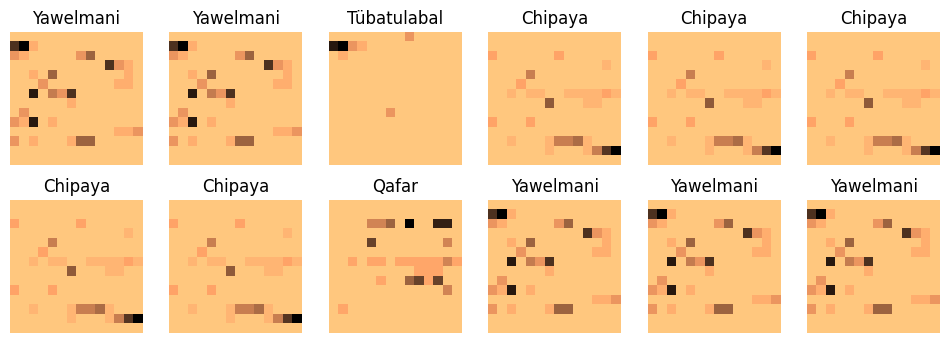

4.393367346938776

In [224]:
# find closest matches
origin = (X * MAX_VALUE).astype(int)

closest_idx, closest, closest_diff = get_closest_matches(origin, generated, n=NUM_LANGS)
closest_language_names = np.take(languages[:, 1], closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=2, c=6, size=(12, 4))

np.mean(closest_diff)

In [225]:
# find exact matches

exact_idx = get_exact_matches_indices(origin, generated)
exact = np.take(X, exact_idx)
exact_language_names = np.take(languages[:, 1], exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

origin.shape, exact_idx.shape

No exact matches. Noice!


((2527, 14, 14, 1), (0,))

In [226]:
from cldfbench import get_dataset

wals = get_dataset("wals").cldf_reader()

param_df = (
    pd.DataFrame(wals.iter_rows("ParameterTable"))
    .set_index(["Area", "Chapter"])
    .drop(columns=["Description", "Contributor_ID"])
)

param_df = param_df[
    ~param_df.index.get_level_values("Area").isin(["Sign Languages", "Other"])
]

param_df.head(5)

ID  \
Area      Chapter                                   
Phonology Consonant Inventories                1A   
          Vowel Quality Inventories            2A   
          Consonant-Vowel Ratio                3A   
          Voicing in Plosives and Fricatives   4A   
          Voicing and Gaps in Plosive Systems  5A   

                                                                              Name  
Area      Chapter                                                                   
Phonology Consonant Inventories                              Consonant Inventories  
          Vowel Quality Inventories                      Vowel Quality Inventories  
          Consonant-Vowel Ratio                              Consonant-Vowel Ratio  
          Voicing in Plosives and Fricatives    Voicing in Plosives and Fricatives  
          Voicing and Gaps in Plosive Systems  Voicing and Gaps in Plosive Systems